In [7]:
import os, sys

parent_path = os.path.abspath(os.pardir)
if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

In [50]:
import re
import emoji
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import dbscan
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, learning_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import pairwise_distances
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from text.contractions import contractions_dict
from text.processing import TweetProcessor

import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load labeled data

In [20]:
#tweet = pd.read_csv("tweets.txt", 
#                    sep="<_;_>", 
#                    parse_dates=["timestamp"], 
#                    error_bad_lines=False, 
#                    engine="python"
#                   )

tweet = pd.read_csv("tweets_bitcoin_labels.csv")

print(tweet.shape)
tweet.head(2)

(1143, 3)


,tweet_id,text,label
0,1010305263885279233,Btc was jus under 6k,-1.0
1,1010307132040699904,"Bitcoin Drops to Within 2018 Low Close to $6,0...",-1.0


Process raw texts

In [51]:
tweet["text_clean"] = np.nan

for i,row in tweet.iterrows():
    processor = TweetProcessor(row.text)
    processor.process_text()
    tweet.loc[i, "text_clean"] = processor.text
    
tweet.head(2)

Remove duplicates

In [52]:
def _remove_technical_words(texts):
    def _replace_multiple(text, repl_dict):
        regex = re.compile("(%s)" % "|".join(map(re.escape, repl_dict.keys())))
        return regex.sub(lambda x: repl_dict[x.string[x.start(): x.end()]], text)
    repl_dict = {"num":"", "url": ""}
    return texts.map(lambda x: _replace_multiple(x, repl_dict))

def text_clustering(texts, vocab_size=None):    
    texts = _remove_technical_words(texts).map(lambda x: " ".join(x.split()))
    texts.replace({"": "empty_text"}, inplace=True)
    vectors = CountVectorizer(max_features=vocab_size).fit_transform(texts)
    D = pairwise_distances(vectors, metric="manhattan")
    _, cluster_idxs = dbscan(D, eps=4, min_samples=1, metric="precomputed")
    return cluster_idxs

(1139, 12)


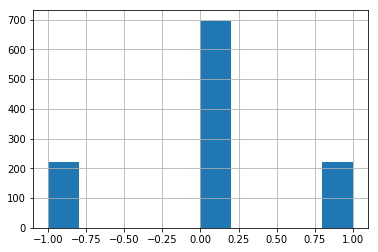

In [53]:
tweet["cluster_idx"] = text_clustering(tweet["text_clean"])
tweet.drop_duplicates(subset=["cluster_idx"], inplace=True)

print(tweet.shape)
tweet["label"].hist();

Add other features

In [46]:
def add_extra_features(tweet):
    # Length-based features
    tweet["text_len"] = tweet["text_clean"].str.len()
    tweet["num_words"] = tweet["text_clean"].str.split().map(len)
    tweet["avg_word_len"] = tweet["text_clean"].str.split().map(lambda x: len("".join(x))) / tweet["num_words"]

    # Vader sentiment
    tweet["vader_pos"] = np.nan
    tweet["vader_neg"] = np.nan
    tweet["vader_neu"] = np.nan
    tweet["vader_comp"] = np.nan
    vader_analyzer = SentimentIntensityAnalyzer()
    for i,row in tweet.iterrows():
        vader_output = vader_analyzer.polarity_scores(row.text)
        tweet.loc[i, "vader_pos"] = vader_output["pos"]
        tweet.loc[i, "vader_neg"] = vader_output["neg"]
        tweet.loc[i, "vader_neu"] = vader_output["neu"]
        tweet.loc[i, "vader_comp"] = vader_output["compound"]
    return tweet

In [47]:
tweet = add_extra_features(tweet)

### Modeling

In [48]:
class TextStats(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.cols_to_use = ["text_len",  "num_words", "avg_word_len", 
                            "vader_pos",  "vader_neg", "vader_neu", "vader_pos", 
                            "vader_comp"
                           ]
        return self
    
    def transform(self, data):
        return data[self.cols_to_use]

    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [49]:
%%time

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=13)

combined_features = FeatureUnion([("bag_of_words", Pipeline([("selector", 
                                                              ItemSelector(key="text_clean")),
                                                             ("vectorizer", 
                                                              TfidfVectorizer(analyzer="word")),                                                             
                                                            ])),
                                 # ("LDA", Pipeline([("selector", 
                                 #                    ItemSelector(key="text_clean")),
                                 #                   ("vectorizer", 
                                 #                    TfidfVectorizer(analyzer="word")),
                                 #                   ("decompositor", 
                                 #                    LatentDirichletAllocation(
                                 #                        learning_method="batch",
                                 #                        random_state=13))
                                 #                  ])),
                                  ("extractor_pipe", TextStats())
                                 ])

pipe = Pipeline([
    ("features", combined_features),
    ("classify", LogisticRegression(class_weight="balanced"))
])

param_grid = {# Logistic regression
              "classify__C": [.5],
              "classify__penalty": ["l1"],
              # Bag-of-words
              "features__bag_of_words__vectorizer__binary": [False],
              "features__bag_of_words__vectorizer__stop_words": [None],
              "features__bag_of_words__vectorizer__lowercase": [True],
              "features__bag_of_words__vectorizer__max_features": [1500],
              "features__bag_of_words__vectorizer__ngram_range": [(1,2)],
              "features__bag_of_words__vectorizer__use_idf": [False],
              "features__bag_of_words__vectorizer__smooth_idf": [False],
              "features__bag_of_words__vectorizer__norm": [None],
              "features__bag_of_words__vectorizer__sublinear_tf": [False],
              # LDA
              #"features__LDA__vectorizer__stop_words": [None],
              #"features__LDA__vectorizer__lowercase": [True],
              #"features__LDA__vectorizer__max_features": [500],
              #"features__LDA__vectorizer__ngram_range": [(1,1)],
              #"features__LDA__vectorizer__use_idf": [False],
              #"features__LDA__vectorizer__smooth_idf": [False],
              #"features__LDA__vectorizer__norm": [None],
              #"features__LDA__vectorizer__sublinear_tf": [False],
              #"features__LDA__decompositor__n_components": [2],
              #"features__LDA__decompositor__max_iter": [10],
             }

grid_search = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           scoring=["f1_macro", "precision_macro", "recall_macro"],
                           cv=cv,
                           refit="f1_macro",
                           verbose=1,
                           n_jobs=-1,
                           return_train_score=True);

grid_search.fit(tweet, tweet.label);
best_ind = grid_search.best_index_

print("best params: {}".format(grid_search.best_params_))
print("best test F1: {:.2f}".format(grid_search.cv_results_["mean_test_f1_macro"][best_ind]))
print("best test precision: {:.2f}".format(grid_search.cv_results_["mean_test_precision_macro"][best_ind]))
print("best test recall: {:.2f}".format(grid_search.cv_results_["mean_test_recall_macro"][best_ind]))

Fitting 100 folds for each of 1 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished


best params: {'classify__C': 0.5, 'classify__penalty': 'l1', 'features__bag_of_words__vectorizer__binary': False, 'features__bag_of_words__vectorizer__lowercase': True, 'features__bag_of_words__vectorizer__max_features': 1500, 'features__bag_of_words__vectorizer__ngram_range': (1, 2), 'features__bag_of_words__vectorizer__norm': None, 'features__bag_of_words__vectorizer__smooth_idf': False, 'features__bag_of_words__vectorizer__stop_words': None, 'features__bag_of_words__vectorizer__sublinear_tf': False, 'features__bag_of_words__vectorizer__use_idf': False}
best test F1: 0.61
best test precision: 0.64
best test recall: 0.60
CPU times: user 594 ms, sys: 75.9 ms, total: 670 ms
Wall time: 7.86 s


In [220]:
def plot_coefficients(gs, label="positive", num=30):
    labels = {"positive": 2, "neutral": 1, "negative":0}
    ind = labels[label]
    coefs_pos = gs.best_estimator_.steps[1][1].coef_[ind,:]
    idxs_sorted = np.argsort(np.abs(coefs_pos))[::-1][:num]
    
    feature_union = gs.best_estimator_.steps[0][1].transformer_list
    vectors_bow = feature_union[0][1].steps[1][1]
    vocab_bow = {v:k for k,v in vectors_bow.vocabulary_.items()}    
    n_features = max(vocab_bow.keys())
    feature_dict = vocab_bow
    
    if "features__LDA__decompositor__n_components" in gs.best_params_:
        n_topics = grid_search.best_params_["features__LDA__decompositor__n_components"]
        lda_dict = dict(zip(range(n_features + 1, n_features + 1 + n_topics), 
                            ["LDA topic #" + str(x) for x in range(n_topics)]))
        feature_dict = {**feature_dict, **lda_dict}
        n_features += n_topics
    
    other_cols = feature_union[-1][1].cols_to_use    
    other_dict = dict(zip(range(n_features + 1, n_features + 1 + len(other_cols)), other_cols))
    feature_dict = {**feature_dict, **other_dict}
    coefs = coefs_pos[idxs_sorted]
    words = [feature_dict[i] for i in idxs_sorted]
    words_emoji = [":" + w + ":" if ":" + w + ":" in emoji.EMOJI_ALIAS_UNICODE else w for w in words]
    colors = ["red" if x<0 else "green" for x in coefs]

    fig, ax = plt.subplots(figsize=(16,4))
    sns.barplot(x=words_emoji, y=np.abs(coefs), palette=colors);
    sns.despine();
    plt.xticks(rotation=60, fontsize=9);
    ax.grid(axis="y", linestyle="--", color="gray");
    ax.set_title(f"Top {num} coefficients for {label} class");

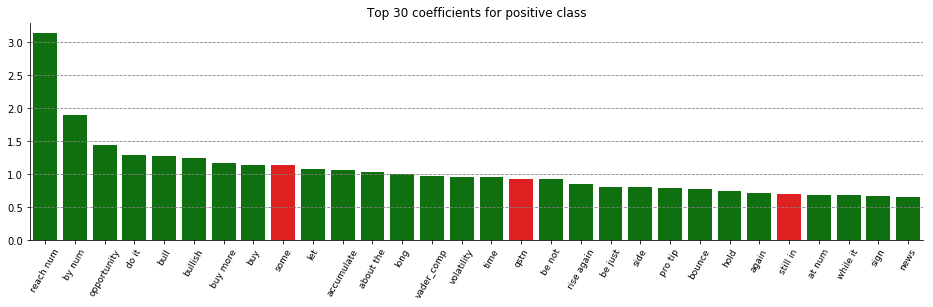

In [224]:
plot_coefficients(grid_search, label="positive", num=30)

In [225]:
def plot_learning_curve(**kwargs):
    plt.figure(figsize=(10,6))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '.-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '.-', color="g",
             label="Cross-validation score")

    plt.title("Learning curve")
    plt.legend(loc="best");
    plt.grid();
    plt.xlabel("Training examples");
    plt.ylabel("Score");

[learning_curve] Training set sizes: [ 409  477  545  613  682  750  818  886  954 1023]


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.5s finished


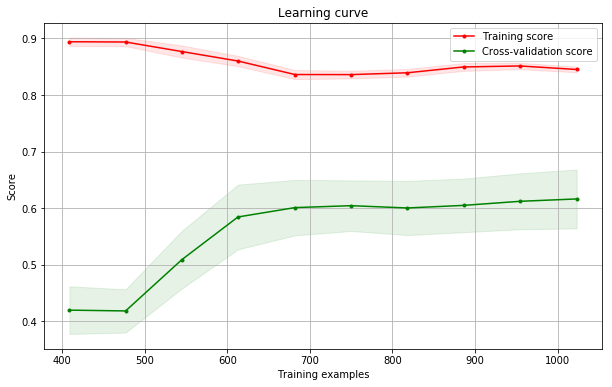

In [226]:
train_sizes, train_scores, test_scores = \
learning_curve(estimator=pipe,
               train_sizes=np.linspace(start=0.4, stop=1.0, num=10),
               X=tweet,
               y=tweet.label,
               cv=cv,
               scoring="f1_macro",
               n_jobs=-1,
               verbose=1,
               random_state=13
              )

plot_learning_curve(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores)

Fitting 100 folds for each of 1 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


Normalized confusion matrix


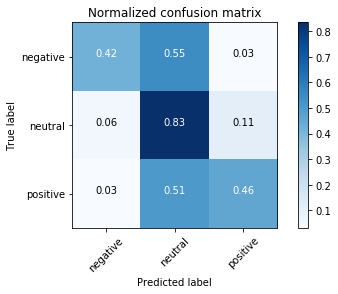

In [227]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


X_train, X_test, y_train, y_test = train_test_split(tweet, tweet.label, test_size=0.3, random_state=13)
grid_search.fit(X_train, y_train);
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix,
                      classes=["negative", "neutral", "positive"], 
                      normalize=True,
                      title='Normalized confusion matrix')

Make out-of-sample predictions

In [94]:
data = pd.read_csv("tweets.txt", sep="<_;_>", engine="python")
data = data.loc[data.asset=="Bitcoin"]

In [95]:
data["text_clean"] = data["text"].map(process_text)
print(data.shape)

(148922, 9)


In [96]:
data = data.loc[~data.tweet_id.isin(tweet.tweet_id)]
print(data.shape)

(147801, 9)


In [97]:
data.drop_duplicates(subset=["text_clean"], inplace=True)
print(data.shape)

(84204, 9)


In [98]:
data = add_extra_features(data)
print(data.shape)

(84204, 16)


In [100]:
data.dropna(inplace=True)

In [189]:
data.head(1)

,asset,tweet_id,timestamp,author_name,author_id,followers,text,truncated,text_clean,text_len,num_words,avg_word_len,vader_pos,vader_neg,vader_neu,vader_comp,proba_pos,label
40156,Bitcoin,1010190932774449152,2018-06-22 16:01:01,Marxist Crypto 🐺⚒🌲,259856497,1742,🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂🐂 Bitcoin bulls...,False,:ox: :ox: :ox: :ox: :ox: :ox: :ox: :ox: :ox: :...,337,58,4.827586,0.0,0.0,1.0,0.0,0.999995,NaN


In [191]:
data["proba_neg"] = grid_search.predict_proba(data)[:,0]
data.sort_values(by="proba_neg", ascending=False, inplace=True)

In [192]:
data["label"] = np.nan
data[["tweet_id", "text", "proba_neg", "label"]].to_csv("tweets_bitcoin_proba.csv", index=False)

Add labels to existing ones

In [193]:
manual = pd.read_csv("tweets_bitcoin_proba.csv").dropna()

In [194]:
tweet = pd.read_csv("tweets_bitcoin_labels.csv")

In [196]:
tweet.head(1)

,tweet_id,text,label
0,1010305263885279233,Btc was jus under 6k,-1


In [195]:
data.head(1)

,asset,tweet_id,timestamp,author_name,author_id,followers,text,truncated,text_clean,text_len,num_words,avg_word_len,vader_pos,vader_neg,vader_neu,vader_comp,proba_pos,label,proba_neg
12543,Bitcoin,1010515217531396096,2018-06-23 13:29:36,ok,947746713577463810,2265,Bitcoin Price Drops to Within $100 of 2018 Low...,True,price drop to within num of num low the price ...,88,20,3.45,0.0,0.167,0.833,-0.4939,0.000072,NaN,0.954529


In [197]:
cols_to_use = ["tweet_id", "text",]

tweet = pd.concat([tweet, pd.merge(data[cols_to_use], manual[["tweet_id", "label"]], on="tweet_id")],
                  ignore_index=True)

In [198]:
tweet.shape

(1143, 3)

In [201]:
tweet.to_csv("tweets_bitcoin_labels_2.csv", index=False)